# exploring pandemic death data from the US CDC

### not interested in the details?  skip to [here](#US-deaths-since-2014); or see slides at [totaldeaths.net](https://totaldeaths.net/).

- motivation
    - https://www.businessinsider.com/yale-study-excess-deaths-nearly-twice-official-covid-19-count-2020-4?op=1
        - excess deaths exceed deaths officially attributed to covid, in US and elsewhere.
        - reliant on figures from the National Center for Health Statistics (NCHS, part of the CDC).
        - at a time when traffic fatalities were in steep decline due to stay-at-home orders.
    - we exclude accidents, overdoses, suicides, etc by looking mostly at deaths from natural causes.
    - we ignore specific cause of death; we also compare general deaths with official covid deaths.
- comparisons
    - https://www.cdc.gov/nchs/nvss/vsrr/covid19/excess_deaths.htm
        - 13 "dashboards" but none show the excess deaths directly
        - at best they show excess deaths as part of total deaths, but not as compared with deaths attributed to covid
    - https://coronavirus.jhu.edu/
        - no 'official' vs excess deaths
    - https://www.economist.com/graphic-detail/coronavirus-excess-deaths-tracker
        - includes other nations as well
        - links to data for all nations in one place
- data sources
    - mmwr = [Morbidity and Mortality Weekly Report](https://en.wikipedia.org/wiki/Morbidity_and_Mortality_Weekly_Report)
    - baseline dataset: 2014-2019
        - https://data.cdc.gov/NCHS/Weekly-Counts-of-Deaths-by-State-and-Select-Causes/3yf8-kanr
            - json format:  https://data.cdc.gov/resource/3yf8-kanr.json
                - throttled unless you get an app token.
            - pandas format:  https://dev.socrata.com/foundry/data.cdc.gov/3yf8-kanr
                - no app token needed.
    - current dataset: 2020-ongoing
        - https://data.cdc.gov/NCHS/Weekly-Counts-of-Deaths-by-State-and-Select-Causes/muzy-jte6
        - updated every Thursday to the week_ending_date (always a Saturday) 12 days earlier.
    - every January, the older of the two years in the current dataset is moved to the baseline dataset.
- background
    - <a id='timeliness'></a>Timeliness of Death Certificate Data  https://www.cdc.gov/nchs/data/vsrr/report001.pdf
        - the most recent data points in the current dataset are undercounts due to delays in reporting.
        - timeliness seems to have improved since this 2015 article, but the delay remains significant.
    - note that 52 weeks is just 364 days, so each year has an extra day (or two for leap years);
      thus there is a 53-mmwrweek year every 5-6 years.
    - 2014 and 2020 are the most recent 53-mmwrweek years.

## in case you've heard that covid deaths are inflated,<br/>let's look at deaths from all causes...

In [1]:
# todo compute dataset transition date [when a year moves from current dataset into baseline dataset]
#   first mmwrweek of each year?  whenever we start graphing the new year, ie when we have 2 weeks with start dates in the new year?
# how express the first point of the new year?  easy to do on the pandemic [filled area] graph, but not on the by-year graphs

In [2]:
# to start from zero, run at the commandline: 
# pip install jupyterlab numpy pandas matplotlib sodapy

# external dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sodapy import Socrata

use_dark_background = 0
if use_dark_background:
    plt.style.use('dark_background')
else:
    plt.style.use('default')

In [3]:
# data loading details

# here we save the downloaded file for reuse to reduce bandwidth;
# and besides: "Requests made without an app_token will be subject to strict throttling limits."

from os import makedirs
from os.path import join, exists
from pickle import load

data_code_by_dataset = dict(
    current='muzy-jte6',
    baseline='3yf8-kanr',
)


def download_data(data_code, data_path):
    app_token = None  # no token needed for public datasets downloaded via Socrata.
    client = Socrata("data.cdc.gov", app_token)
    data = list(client.get_all(data_code))
    
    # write data to local file
    from pickle import dump
    with open(data_path, 'wb') as f:
        dump(data, f)
        
    return data

def read_local_data(data_path):
    with open(data_path, 'rb') as f:
        data = load(f)
    return data

def read_data(dataset_name):
    data_dir = 'data'
    fname = dataset_name + '.pickl'
    fpath = join(data_dir, fname)
    if not exists(data_dir):
        makedirs(data_dir)
    if exists(fpath):
        return read_local_data(fpath)
    else:
        data_code = data_code_by_dataset[dataset_name]
        return download_data(data_code, fpath)

In [4]:
# apparently the flu/pneumonia definition was adjusted between the baseline and current datasets.
# we will replace both the baseline and current flu/pneumonia columns with this generic name.
flu_col_generic = 'influenza_and_pneumonia_jxx_renamed'

years_with_extra_week = (2014, 2020)
def has_extra_week(year):
    return year in years_with_extra_week
def nweeks(year):
    return 52 + (1 if year in years_with_extra_week else 0)

In [5]:
# load the "current" dataset (updated weekly)
# todo n_extra_rows / nlocations in 2021 is no longer an integer--fewer locations now being reported?

data = read_data('current')
#display(data)

# create the current dataframe
current_df = pd.DataFrame(data).apply(pd.to_numeric, errors='ignore')

current_df_years = current_df.mmwryear.unique()
if not len(current_df_years) == 3:
    print('oops expected just two years, instead found', current_df_years)
#assert len(current_df_years) == 2   # generally this holds, but on 20jan2022 current_df_years==[2020 2021 2022]
assert len(current_df_years) in (2, 3)
nlocations = len(current_df.jurisdiction_of_occurrence.unique())
n_extra_rows = len(data) - 53 * nlocations
n_extra_weeks = n_extra_rows / nlocations
if n_extra_weeks != int(n_extra_weeks):
    print('todo: check current dataset for missing locations')

year_range_str = '-'.join(str(yr) for yr in current_df_years)
print(f'''
    The current [{year_range_str}] dataset is {len(data)} rows,
    {n_extra_rows} rows (ie {n_extra_weeks} weeks) more than 2020's 53 weeks X 54 locations = {53 * 54} rows
    [2020 was a 53-mmwrweek year]''')
#print('''
#    the first row is:
#    ''')
#display(data[0])

current_df = current_df.rename(columns=dict(
    weekendingdate='week_ending_date',
    allcause='all_cause',
    naturalcause='natural_cause',
    influenza_and_pneumonia_j09_j18=flu_col_generic,
))

latest_mmwryear = current_df.mmwryear.max()
latest_mmwryear_is_complete = 0

latest_mmwrweek = current_df.query(f'mmwryear == {latest_mmwryear}').mmwrweek.max()
latest_week_ending_date = current_df.query(f'mmwryear == {latest_mmwryear} and mmwrweek == {latest_mmwrweek}').week_ending_date.unique()[0]
display(f"latest mmwryear is {latest_mmwryear}")
display(f"latest mmwrweek is {latest_mmwrweek}")
display(f"latest week_ending_date is {latest_week_ending_date}")
#display(w.jurisdiction_of_occurrence.unique())
latest_week_ending_date_displayed = None
    # will be computed later

loc_as_xx = 'US'
loc_by_abbrev = dict(
    US='United States',
    CA='California',
    NY='New York',
    NJ='New Jersey',
    OH='Ohio',
    PA='Pennsylvania',
)
loc = loc_by_abbrev[loc_as_xx]
#mmwrweek_and_week_ending_date = current_df.query(f"mmwryear == {latest_mmwryear} and jurisdiction_of_occurrence == {loc}''")
time_df = current_df.query(f"jurisdiction_of_occurrence == '{loc}'")[['mmwryear', 'mmwrweek', 'week_ending_date']]

#mmwrweek_to_week_ending_date = dict(zip(mmwrweek_and_week_ending_date.mmwrweek, mmwrweek_and_week_ending_date.week_ending_date))
year_and_week_to_week_ending_date = dict(zip(zip(time_df.mmwryear, time_df.mmwrweek), time_df.week_ending_date))
print('latest year and week', max(year_and_week_to_week_ending_date.items()))
display(current_df)


    The current [2020-2021-2022] dataset is 7884 rows,
    5022 rows (ie 93.0 weeks) more than 2020's 53 weeks X 54 locations = 2862 rows
    [2020 was a 53-mmwrweek year]


'latest mmwryear is 2022'

'latest mmwrweek is 41'

'latest week_ending_date is 2022-10-15'

latest year and week ((2022, 41), '2022-10-15')


,data_as_of,jurisdiction_of_occurrence,mmwryear,mmwrweek,week_ending_date,all_cause,natural_cause,septicemia_a40_a41,malignant_neoplasms_c00_c97,diabetes_mellitus_e10_e14,...,flag_sept,flag_otherunk,flag_inflpn,flag_diab,flag_alz,flag_clrd,flag_nephr,flag_stroke,flag_hd,flag_neopl
0,2022-10-26T00:00:00.000,United States,2020,1,2020-01-04,60177,55009,843.0,11569.0,1829.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-10-26T00:00:00.000,United States,2020,2,2020-01-11,60734,55754,861.0,11962.0,1942.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-10-26T00:00:00.000,United States,2020,3,2020-01-18,59362,54516,829.0,11701.0,1819.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-10-26T00:00:00.000,United States,2020,4,2020-01-25,59162,54401,828.0,11879.0,1864.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-10-26T00:00:00.000,United States,2020,5,2020-02-01,58844,54007,811.0,11964.0,1828.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7879,2022-10-26T00:00:00.000,Puerto Rico,2022,37,2022-09-17,600,578,14.0,101.0,65.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7880,2022-10-26T00:00:00.000,Puerto Rico,2022,38,2022-09-24,708,687,17.0,103.0,69.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7881,2022-10-26T00:00:00.000,Puerto Rico,2022,39,2022-10-01,585,571,19.0,84.0,53.0,...,NaN,NaN,NaN,NaN,NaN,Suppressed (counts 1-9),NaN,NaN,NaN,NaN
7882,2022-10-26T00:00:00.000,Puerto Rico,2022,40,2022-10-08,483,483,NaN,83.0,43.0,...,Suppressed (counts 1-9),NaN,Suppressed (counts 1-9),NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# combine with baseline death data 2014-2018

data = read_data('baseline')
print(f'\nbaseline has {len(data)} rows')
baseline_df = pd.DataFrame(data).apply(pd.to_numeric, errors='ignore')
yr_min, yr_max = baseline_df.mmwryear.min(), baseline_df.mmwryear.max()
n_yrs = yr_max - yr_min + 1
n_locs = len(baseline_df.jurisdiction_of_occurrence.unique())
print(f'compare with {n_yrs} years X 52 weeks/year * {n_locs} locations =  {n_yrs * 52 * n_locs}')
print(f'thus there is a 53rd mmwr week (in 2014)--this happens every 5 or 6 years\n')

# align column names with latest weekly dataset, for concatenation below
baseline_df = baseline_df.rename(columns=dict(
    weekendingdate="week_ending_date",
    allcause="all_cause",
    naturalcause="natural_cause",
    influenza_and_pneumonia_j10=flu_col_generic,
))

display(baseline_df)


baseline has 16902 rows
compare with 6 years X 52 weeks/year * 54 locations =  16848
thus there is a 53rd mmwr week (in 2014)--this happens every 5 or 6 years



,jurisdiction_of_occurrence,mmwryear,mmwrweek,week_ending_date,all_cause,natural_cause,septicemia_a40_a41,malignant_neoplasms_c00_c97,diabetes_mellitus_e10_e14,alzheimer_disease_g30,...,flag_inflpn,flag_nephr,flag_sept,flag_diab,flag_otherunk,flag_alz,flag_clrd,flag_stroke,flag_hd,flag_neopl
0,United States,2014,1,2014-01-04T00:00:00.000,54065,50189,882.0,11244.0,1654.0,1780.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,United States,2014,2,2014-01-11T00:00:00.000,56353,52450,905.0,11504.0,1735.0,1917.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,United States,2014,3,2014-01-18T00:00:00.000,54769,51043,919.0,11496.0,1660.0,1914.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,United States,2014,4,2014-01-25T00:00:00.000,54223,50560,845.0,11629.0,1602.0,1862.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,United States,2014,5,2014-02-01T00:00:00.000,54074,50402,890.0,11584.0,1586.0,1867.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16897,Puerto Rico,2019,48,2019-11-30T00:00:00.000,619,568,NaN,113.0,62.0,53.0,...,NaN,NaN,Suppressed (counts 1-9),NaN,NaN,NaN,NaN,NaN,NaN,NaN
16898,Puerto Rico,2019,49,2019-12-07T00:00:00.000,555,530,15.0,109.0,62.0,46.0,...,Suppressed (counts 1-9),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16899,Puerto Rico,2019,50,2019-12-14T00:00:00.000,526,492,NaN,91.0,56.0,39.0,...,NaN,NaN,Suppressed (counts 1-9),NaN,NaN,NaN,NaN,NaN,NaN,NaN
16900,Puerto Rico,2019,51,2019-12-21T00:00:00.000,577,533,17.0,92.0,59.0,34.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
all_data = pd.concat([baseline_df, current_df])
loc_data_raw = all_data.query(f"jurisdiction_of_occurrence == '{loc}'")
n_entire_yrs_in_baseline = len(baseline_df.mmwryear.unique())
n_entire_yrs_in_current = len(current_df.mmwryear.unique()) - 1   # subtract cuz the current year is [almost!] never entire  # todo almost!
n_entire_yrs = n_entire_yrs_in_baseline + n_entire_yrs_in_current
print(f'\ndata from 2014 thru the present totals {len(loc_data_raw)} rows,\n'
      + f'whereas {n_entire_yrs} years X 52 weeks per year = {n_entire_yrs * 52} weeks,\n'
      + f'plus 2 weeks because 2014 and 2020 were 53-mmwrweek years,\n'
      + f'so we are {len(loc_data_raw) - (n_entire_yrs * 52 + 2)} weeks into the current year\n')


data from 2014 thru the present totals 459 rows,
whereas 8 years X 52 weeks per year = 416 weeks,
plus 2 weeks because 2014 and 2020 were 53-mmwrweek years,
so we are 41 weeks into the current year



In [8]:
def select_col(df, col, start_year=2014):
    return pd.DataFrame({
        yr: pd.Series(
            df.query(f"mmwryear == {yr}")[col].values,
            index=df.query(f"mmwryear == {yr}").mmwrweek
        )
        for yr in range(start_year, latest_mmwryear+1)
    })
all_cod_by_yr = select_col(loc_data_raw, 'all_cause')
nat_cod_by_yr = select_col(loc_data_raw, 'natural_cause')
print(f'\n{len(nat_cod_by_yr)} rows (because 2014 and 2020 were 53-mmwrweek years)\n')
#display('years included: ' + ' '.join(str(yr) for yr in nat_cod_by_yr.columns))
#display(nat_cod_by_yr)


53 rows (because 2014 and 2020 were 53-mmwrweek years)



In [9]:
#plot_df(all_cod_by_yr, f'{loc_as_xx} deaths by all causes, with artifacts from incomplete data', order=reversed, xylegend=(1.15,0.8))

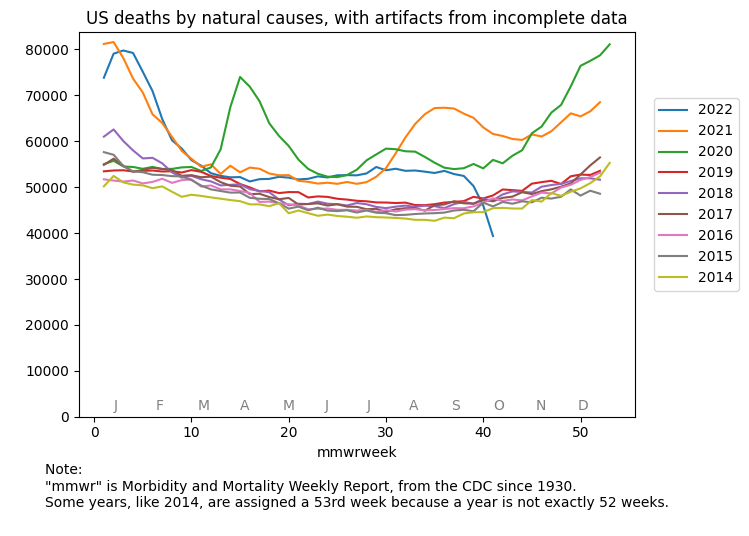

In [10]:
# plot data by year

def plot_df(df, title=None, caption=None, order=None, xylegend=None, 
            xycaption=None, fill=None, output_file=None):
    
    if not xylegend:
        xylegend = (1.15, 0.8)
        
    fig = plt.figure()
    
    if title:
        plt.title(title)
        
    ax = fig.gca()
        # gca stands for 'get current axes'
    # reverse columns so that legend better corresponds to location of data [most recent year is uppermost]
    if order == 'by_sum':
        columns = [col for summ, col in reversed(sorted((df[col].sum(), col) for col in df.columns))]
    elif order == 'by_final_value':
        columns = [col for summ, col in reversed(sorted((df[col].iat[-1], col) for col in df.columns))]
    else:
        columns = order(df.columns) if order else df.columns
    def num_points_in_column(series):
        return len(list(x for x in series if x is not None and not np.isnan(x)))
    for yr in columns:
        if num_points_in_column(df[yr]) > 1:  # todo how graph the 1st point of the new year?
            df[yr].plot(kind='line',x='mmwrweek', y='natural_cause', ax=ax)
    
    # set y-axis to start at zero
    ax.set_ylim(bottom=0)
    if fill:
        y1, y2, *etc = fill
        where = etc[0] if etc else None
        ax.fill_between(df.index, df[y1], df[y2], where=where, color='gray', alpha=0.3)
    fig.legend(bbox_to_anchor=xylegend)  #loc='lower right')
    #print(fig.legend.__doc__)
    
    if caption:
        cx, cy = 0, -.1
        if xycaption:
            cx, cy = xycaption
        fig.text(cx, cy, caption) # , ha='center')

    # playing with month pseudo-axis
    # data coords dont allow labels outside of the data box.
    #ax.annotate('Jan', xy=(1, -200), xycoords='data')
    ymax = df.max().max()
        # df.max is greatest from each col; df.max.max is max of all cols
    ypos_year = ymax / 12
    ypos_month = ymax / 60
    months0 = 'Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec'.split()
    months0 = [month[0] for month in months0]   # ie ['J', 'F', ...]
    months0_offset = 2  # was 1.5 for three-letter month names
    months = months0
    if df.index.max() > 53:
        latest_year, latest_month, day = [int(n) for n in latest_week_ending_date_displayed.split('-')]
        # if we're less than halfway thru the last month, dont display it.
        if day < 10:
            latest_month -= 1
        # compute number of times to add entire months0
        # eg in 2022, need to add entire months0 once for 2021.
        additional_full_years = latest_year - 2020 - 1
            # "- 1" cuz months already contains one copy of months0
        months += additional_full_years * months0 + months0[:latest_month]
        year_margin = 1.5  # unit is weeks
        year_width = 7
        nweeks_so_far = 0
        for year in range(2020, 1 + latest_year):
            start = nweeks_so_far
            end = start + nweeks(year)
            plt.axvline(x = start, color = 'gray', linewidth=0.5)
            ax.annotate(str(year), xy=(start + year_margin, ypos_year), xycoords='data', color='gray')
            ax.annotate(str(year), xy=(end - year_margin - year_width, ypos_year), xycoords='data', color='gray')
            nweeks_so_far = end
    for i, m in enumerate(months):
        # each month name is 2.5-3weeks wide, 
        # so we start each name 1week into its interval
        ax.annotate(m, xy=(months0_offset+i*52/12, ypos_month), xycoords='data', color='gray')
    
    fig.tight_layout()
    plt.show()
    
    if output_file:
        # todo prevent figure caption from being cut off.
        fig.savefig(output_file)

plot_df(
    nat_cod_by_yr, 
    f'{loc_as_xx} deaths by natural causes, with artifacts from incomplete data',
    order=reversed,
    xylegend=(1.15,0.8),
    caption='''
        Note:
        "mmwr" is Morbidity and Mortality Weekly Report, from the CDC since 1930.
        Some years, like 2014, are assigned a 53rd week because a year is not exactly 52 weeks.
    ''',

)

In [11]:
# useful code to avoid using the most incomplete recent data points

from itertools import takewhile

# data from a forthcoming notebook, computed from multiple "current" weekly datasets
undercount_from_latest = [1.6488, 0.3082, 0.1064, 0.0564, 0.0365, 0.0248, 0.0163, 0.0136, 0.0131, 0.0136]

def n_weeks_to_ignore_for_max_undercount(max_undercount):
    return len(list(takewhile((lambda x: x > max_undercount), undercount_from_latest)))

def skip_most_recent(df, nweeks, cols_to_trim=None):
    '''
    called by trim_df_by_year, assumes cols are years 
      eg last col is just two wks cuz new year so nweeks=3 will go to previous col.
    todo but this is also called by trim_df where it should not go to previous col;
      tho will never return a buggy result in practice.
    
    todo replace cols_to_trim with a groupby callable
    '''
    weeks_skipped = 0
    if cols_to_trim:
        for col in cols_to_trim:
            for week in reversed(df.index.values):
                val = df.loc[week, col]
                #print(val,type(val))
                if val is None or np.isnan(val):
                    continue
                if weeks_skipped < nweeks:
                    df.loc[week, col] = None
                    weeks_skipped += 1
        yr = cols_to_trim[0].split()[0]   # shouldnt matter which col we use.
        return int(yr), week
    else:
        for yr in reversed(df.columns):
            for week in reversed(df.index.values):
                val = df.loc[week, yr]
                #print(yr,week, val,type(val))
                if val is None or np.isnan(val):
                    continue
                if weeks_skipped < nweeks:
                    df.loc[week, yr] = None
                    weeks_skipped += 1
                else:
                    return yr, week
            
def trim_df(df, max_undercount, columns=None):
    if not columns:
        columns = df.columns
    n_most_recent_points_to_remove = n_weeks_to_ignore_for_max_undercount(max_undercount)
    last_mmwrweek_to_keep = latest_mmwrweek - n_most_recent_points_to_remove
    last_year, last_week = skip_most_recent(df, n_most_recent_points_to_remove)
    df.loc[df.index > last_week, columns] = None
    return last_week, n_most_recent_points_to_remove

def trim_df_by_year(df, max_undercount, cols=None):
    # skip_most_recent trims the cols, then the return statement removes any cols that were completely trimmed [eg a new jan col]
    n_most_recent_points_to_remove = n_weeks_to_ignore_for_max_undercount(max_undercount)
    last_year, last_week = skip_most_recent(df, n_most_recent_points_to_remove, cols)
    # todo this is for turn-of-year...
    #return df.loc[:, :last_year], last_year, last_week, n_most_recent_points_to_remove
    # todo here in march, no new jan cols to remove
    return df, last_year, last_week, n_most_recent_points_to_remove

def scrub_df(df, max_undercount):
    # scrub the data in two steps:

    # apparently this was corrected; no longer need to remove first point in 2014.
    # 1. remove first point in 2014 because it represents only wed-sat of that week [2014 started on a wednesday]
    # df[2014][1] = None

    # 2. remove the last few points of the current year because reporting is not yet complete.
    df, last_year, last_mmwrweek_kept, n_most_recent_points_removed = trim_df_by_year(df, max_undercount)

    return df, last_year, last_mmwrweek_kept, n_most_recent_points_removed

#display(nat_cod_by_yr)
max_undercount = 0.05   # go back far enough to avoid undercounting by more than this proportion.
all_cod_by_yr, last_year, last_mmwrweek_kept, n_most_recent_points_removed = scrub_df(all_cod_by_yr, max_undercount)

# US deaths since 2014

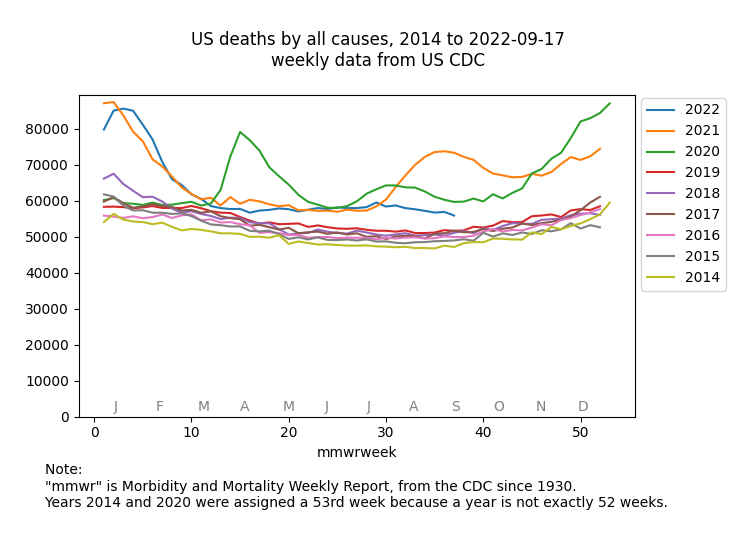

In [12]:
# plot the scrubbed data

latest_week_ending_date_displayed = year_and_week_to_week_ending_date[(last_year, last_mmwrweek_kept)]
month_day = latest_week_ending_date_displayed[5:]
# need at least two data points to graph
# todo distinguish by-year from multi-year graphs, which can show a single point in the new year.
#      thus must move this block into plot_df
if last_mmwrweek_kept < 2:
    end_date = latest_mmwryear - 1
    last_year -= 1
else:
    end_date = latest_week_ending_date_displayed

plot_df(
    all_cod_by_yr,
    f'''
        US deaths by all causes, 2014 to {end_date}
        weekly data from US CDC
    ''',
    caption='''
        Note:
        "mmwr" is Morbidity and Mortality Weekly Report, from the CDC since 1930.
        Years 2014 and 2020 were assigned a 53rd week because a year is not exactly 52 weeks.
    ''',
    #   This dataset is updated every Thursday.
    order=reversed, 
    xylegend=(1.13,0.8),
    #xycaption=(0.2,0.2)
)

Many more people died (of all causes) in 2020 and 2021 than in previous years.  But how many deaths might be due to covid, rather than say suicide or overdose?  Next we look at deaths from all natural causes.

In [13]:
display(f'last_mmwrweek_kept={last_mmwrweek_kept}  latest_week_ending_date_displayed={latest_week_ending_date_displayed}  end_date={end_date}')

'last_mmwrweek_kept=37  latest_week_ending_date_displayed=2022-09-17  end_date=2022-09-17'

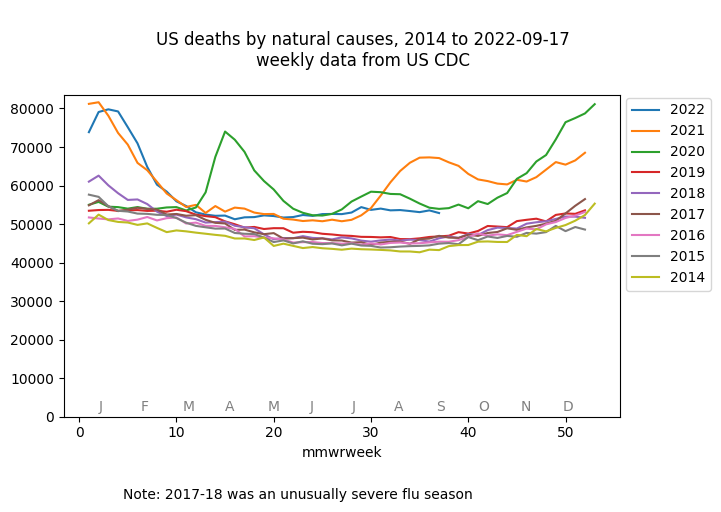

In [14]:
# scrub and plot the data
nat_cod_by_yr, last_year, last_mmwrweek_kept, n_most_recent_points_removed = scrub_df(nat_cod_by_yr, max_undercount)
#if last_mmwrweek_kept < 2:
    #last_year -= 1
    # todo cannot graph a single point for new year in by-year graphs
    #      but can and should in multi-year [filled] graph.

latest_week_ending_date_displayed = year_and_week_to_week_ending_date[(last_year, last_mmwrweek_kept)]
notes = '\n'.join([
    #f'Ignoring the most recent {n_most_recent_points_removed} data points to avoid an undercount of more than {100 * max_undercount}%.',
    '2017-18 was an unusually bad flu season',
])

plot_df(
    nat_cod_by_yr,
    f'''
        US deaths by natural causes, 2014 to {end_date}
        weekly data from US CDC
    ''',
    caption=(f'''Note: 2017-18 was an unusually severe flu season'''),
    xycaption=(0.2, -0.05),
    order=reversed, 
    xylegend=(1.13,0.8)
)

We see much higher weekly deaths from natural causes since week 12 of 2020.  How many more people are dying than we would expect?  For "excess deaths" we simply use 2019 as our baseline and subtract the deaths in 2019 from those in 2020.

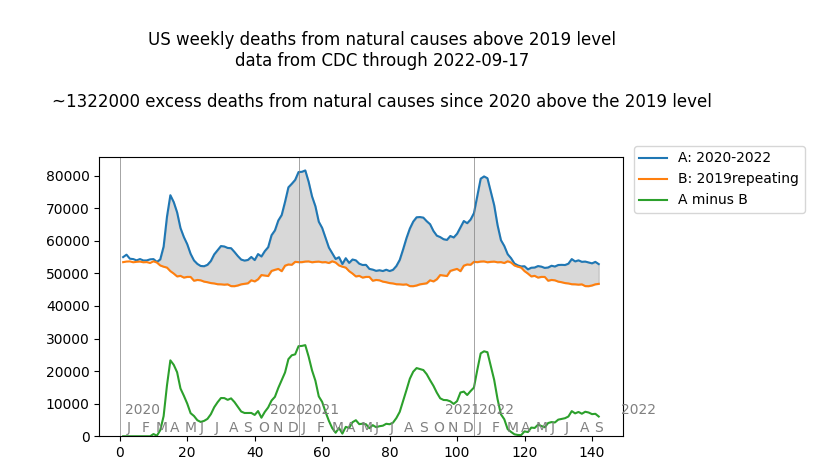

In [15]:
def bracket_pandemic(df, col, final_incomplete_year=None):

    # apply a floor of zero to avoid negative excess deaths
    def floor_zero(x):
        return None if np.isnan(x) else x if x > 0 else 0
    df[col] = df[col].apply(floor_zero)

    # assume negligible covid deaths in the first weeks of 2020
    last_pre_pandemic_mmwrweek = 9
    #df[col].iloc[:last_pre_pandemic_mmwrweek] = 0
        # A value is trying to be set on a copy of a slice from a DataFrame / See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
    df.iloc[:last_pre_pandemic_mmwrweek, df.columns.get_loc(col)] = 0
    
    # remove future weeks of incomplete year
    if final_incomplete_year:
        df.loc[np.isnan(df[final_incomplete_year]), col] = None
    
    return df, df.index > last_pre_pandemic_mmwrweek

def append_series(df, years):
    # this way we lose a value [1st value of 2020]
        #data_us_2020etc = nat_cod_by_yr[2020].append(nat_cod_by_yr[2021], ignore_index=True)
        #data_us_2020etc = data_us_2020etc.reindex(range(1, 53 + 52))
    # instead we respect the index!
        #data2021 = pd.Series(nat_cod_by_yr[2021].values[:52], index=range(54, 54 + 52))
        #data_us_2020etc = nat_cod_by_yr[2020].append(data2021)
    # generalized here
    def weeks_in_year(year):
        return {2014: 53, 2020: 53}.get(year, 52)
    def get_data(year):
        return df[year][:weeks_in_year(year)]
    year0, *years = years
    #print(type(df),type(df[year0]),type(df[year0].values))
    all_series = get_data(year0)
    for yr in years:
        n_weeks = weeks_in_year(yr)
        start = len(all_series) + 1
        end = start + n_weeks
        #all_series = all_series.append(pd.Series(df[yr].values[:n_weeks], index=range(start, end)))
        all_series = all_series.append(type(df[yr])(df[yr].values[:n_weeks], index=range(start, end)))
    return all_series

pandemic_years = list(range(2020, 1 + last_year))
data_us_2020etc = append_series(nat_cod_by_yr, pandemic_years)

def baseline2019(years):
    # to use 2019 [with 52 weeks] as a baseline for 2020 [with 53 weeks],
    # we repeat week 1 of 2019 as week 53.
    year0, *years_etc = years
    wrap_2019 = nat_cod_by_yr[2019].copy()
    if has_extra_week(year0):
        wrap_2019.loc[53] = wrap_2019[1]
    repeat_2019 = wrap_2019
    for yr in years_etc:
        # add a 2nd copy of 2019 as baseline for 2021 [both years have 52 weeks]
        nwks = nweeks(yr)
        nwks0 = len(repeat_2019.index)
        wrap_2019_2 = pd.Series(wrap_2019.values[:nwks], index=range(1 + nwks0, 1 + nwks0 + nwks))
        repeat_2019 = repeat_2019.append(wrap_2019_2)
    # nullify future weeks
    if np.isnan(data_us_2020etc).any():
        repeat_2019.loc[np.isnan(data_us_2020etc)] = None
    return repeat_2019
repeat_2019 = baseline2019(pandemic_years)

pandemic_years_range_str = '-'.join(str(yr) for yr in (pandemic_years[0], pandemic_years[-1]))
key_a = f'A: {pandemic_years_range_str}'       # eg 'A: 2020-2021'
key_b = 'B: 2019repeating'
key_diff = 'A minus B'
excess_nat_cod_pandemic = pd.DataFrame(
    {
        key_b: repeat_2019,
        key_a: data_us_2020etc,
        key_diff: (data_us_2020etc - repeat_2019),
    },
    index=data_us_2020etc.index
)
excess_nat_cod_pandemic, x_pandemic = bracket_pandemic(excess_nat_cod_pandemic, key_diff)
n_excess_deaths = int(round(excess_nat_cod_pandemic[key_diff].sum(), -3))
plot_df(
    excess_nat_cod_pandemic[[key_a, key_b, key_diff]],
    title=f'''
        US weekly deaths from natural causes above 2019 level
        data from CDC through {end_date}
        
        ~{n_excess_deaths} excess deaths from natural causes since 2020 above the 2019 level
        
    ''',
    xylegend=(1.22, 0.7),
    fill=(key_b, key_a, x_pandemic),
)
excess_nat_cod_pandemic['2020etc_minus_2019'] = excess_nat_cod_pandemic[key_diff]

In [16]:
# compute new trim array for unnatural causes.
glance_at_unnatural_causes = 0
if glance_at_unnatural_causes:
    # deaths from all causes are swamped by deaths from natural causes, so let's look at unnatural causes.
    # how does that sum compare with the CDC's estimate?
    # the CDC used deaths from all causes, and fancier baseline than simply 2019.
    # But using all_causes in 2020 minus 2019:
    all_cod_by_yr, *_ = scrub_df(select_col(loc_data_raw, 'all_cause'), .05)
    all_cod_by_yr['2020_minus_2019'] = all_cod_by_yr[2020] - all_cod_by_yr[2019]
    total_excess_deaths = int(all_cod_by_yr['2020_minus_2019'].sum())
    # todo replace "so far in 2020"
    plot_df(
        all_cod_by_yr[[2020, 2019, '2020_minus_2019']],
        f'''
            US deaths by all causes, 2019 to 2020
            weekly data from US CDC

            {total_excess_deaths} excess deaths from all causes so far in 2020 above the 2019 level
        ''',
        caption=f'''
            Note:
            Ignoring the most recent {n_most_recent_points_removed} data points
            to avoid an undercount of more than {int(100 * max_undercount)}%.
        ''',
        xylegend=(1.22, 0.8)
    )

    # deaths from unnatural causes [suicide, overdose, car accidents, etc]
    # are not categorized in this dataset 
    # but seem to be reported with yet greater delay.
    unnat_cod_by_yr = all_cod_by_yr - nat_cod_by_yr
    plot_df(unnat_cod_by_yr)

How many of these excess deaths were officially attributed to covid?

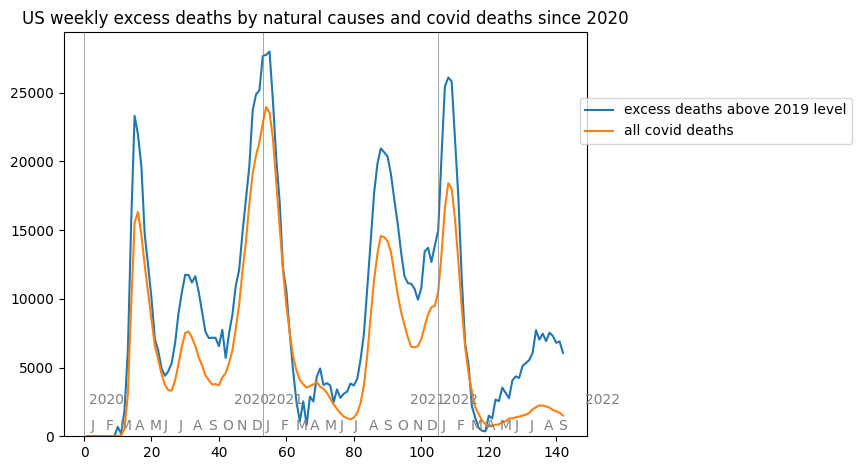

In [17]:
# The CDC MMWR data include deaths of covid as _the_ underlying cause
# and as _one_ contributing cause.

covid_by_yr = select_col(loc_data_raw, 'covid_19_u071_underlying_cause_of_death', 2020)
covid_by_yr, *_ = scrub_df(covid_by_yr, max_undercount)
covid2020etc = append_series(covid_by_yr, pandemic_years)
x = pd.DataFrame(
    {
        #'covid_as_one_cause_of_death': covid['covid_as_one_cause_of_death'],
            # assuming one_cause includes the_cause since it is always slightly higher.
        'excess deaths above 2019 level': excess_nat_cod_pandemic['2020etc_minus_2019'],
        #'all covid deaths': covid['covid_as_the_cause_of_death'],
        'all covid deaths': covid2020etc,
    },
    index=data_us_2020etc.index)
plot_df(
    x,
    title=f'{loc_as_xx} weekly excess deaths by natural causes and covid deaths since 2020',
    xylegend=(1.35,0.8),
)

Excess deaths are greater than covid deaths except around March 2021 and March 2022.  The two curves correlate fairly well.

As a sanity check, let's sum all the individual natural causes of death and compare it with the total that we've been using:

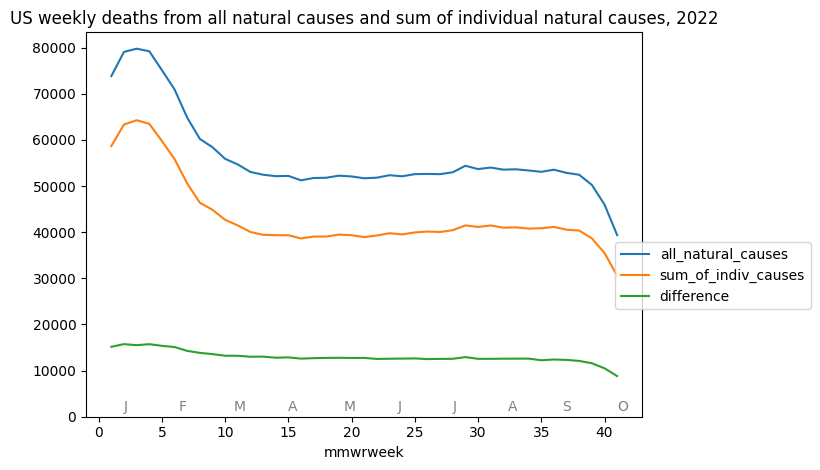

In [18]:
spacetime_columns = ['jurisdiction_of_occurrence', 'mmwryear', 'mmwrweek', 'week_ending_date', 'data_as_of']
aggregate_columns = ['all_cause', 'natural_cause', 'covid_19_u071_multiple_cause_of_death']
flag_columns = list(col for col in loc_data_raw.columns if col.startswith('flag'))
nondisease_columns = spacetime_columns + aggregate_columns + flag_columns
causes_of_death = list(col for col in loc_data_raw.columns if col not in nondisease_columns)
def sanity(yr):
    df = loc_data_raw.query(f'mmwryear == {yr}')
    sanity = pd.DataFrame(
        dict(
            all_natural_causes=df['natural_cause'].values,
            sum_of_indiv_causes=df[causes_of_death].sum(axis=1).values,
            difference=(df['natural_cause'] - df[causes_of_death].sum(axis=1)).values,
            #covid_as_the_cause_of_death=covid['covid_as_the_cause_of_death'],
        ),
        index=df.mmwrweek
    )
    plot_df(
        sanity, 
        title=f'{loc_as_xx} weekly deaths from all natural causes and sum of individual natural causes, {yr}',
        xylegend=(1.25,.5))
    
sanity(2022)

So the causes of death included in the MMWR are just the major ones--they add up to about 75% of the total deaths from natural causes.  However, the difference is fairly constant, so we can see most of the interesting variation in the individual causes of death in the next slide... 

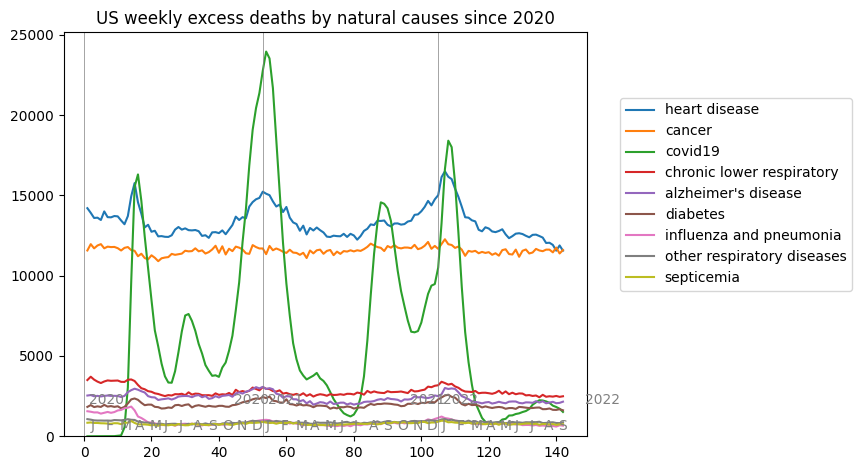

In [19]:
cause_of_death_map = {
    'septicemia_a40_a41': 'septicemia',
    'malignant_neoplasms_c00_c97': 'cancer',
    'diabetes_mellitus_e10_e14': 'diabetes',
    'alzheimer_disease_g30': "alzheimer's disease",
    'influenza_and_pneumonia_jxx_renamed': 'influenza and pneumonia',
    'chronic_lower_respiratory': 'chronic lower respiratory',
    'other_diseases_of_respiratory': 'other respiratory diseases',
    #nephritis_nephrotic_syndrome': 'kidney disease',
    #'symptoms_signs_and_abnormal': 'other diseases',
    'diseases_of_heart_i00_i09': 'heart disease',
    #cerebrovascular_diseases': 'stroke',
    'covid_19_u071_underlying_cause_of_death': 'covid19',
}
# todo apparently only 10colors but we need 12 here!  thus removing two less common cod's for now.

def append_cols_across_years(df, col_map, years):
    def weeks_in_year(year):
        return {2014: 53, 2020: 53}.get(year, 52)
    def get_data(year, index=None):
        n_weeks = weeks_in_year(year)
        df_that_year = df.query(f'mmwryear == {year}')
        if not index:
            index = df_that_year.mmwrweek
        else:
            if len(index) > len(df_that_year):
                start = index[0]
                index = range(start, start + len(df_that_year))
        return pd.DataFrame(
            {
                title: df_that_year[col][:n_weeks].values
                for col, title in col_map.items()
            },
            index=index
        )
    year0, *years = years
    all_series = get_data(year0)
    for yr in years:
        n_weeks = weeks_in_year(yr)
        start = len(all_series) + 1
        end = start + n_weeks
        all_series = all_series.append(get_data(yr, index=range(start, end)))
    return all_series

nat_cods = append_cols_across_years(loc_data_raw, cause_of_death_map, pandemic_years)
trim_df(nat_cods, max_undercount)

plot_df(
    nat_cods, 
    title=f'{loc_as_xx} weekly excess deaths by natural causes since 2020',
    xylegend=(1.35, 0.8),
    order='by_sum'        # todo add order by_final_value cuz that's nearest the legend.
)


Note:
- heart disease deaths peaked when covid deaths peaked.
- <a id="abnormal_rise"></a>deaths [temporarily] attributed to "other diseases" rose dramatically since week 50 in 2020.

Presumably there is not usually a springtime peak in heart attacks, but let's check in the next slide...

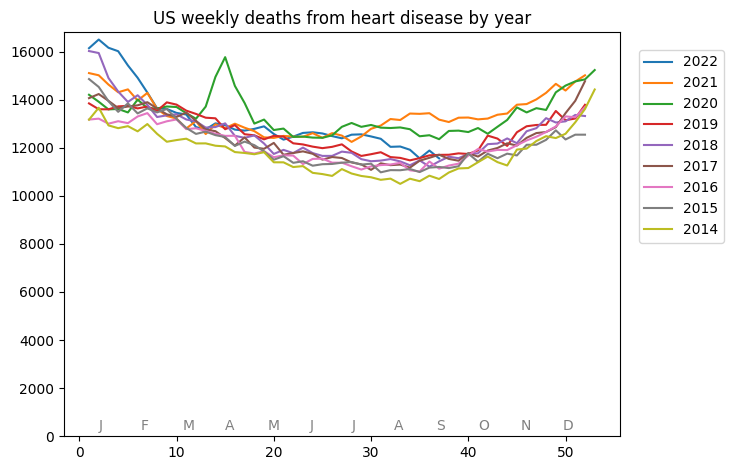

In [20]:
def align53(listt):
    n = len(listt)
    if n < 53:
        listt = np.append(listt, [None] * (53 - n))
    return listt

def abbrev_cod(cod_name):
    return cause_of_death_map[cod_name].split(None, 1)[0]

def plot_cod_thru_yrs(cod_names, title):
    #cod_names = list(cods_by_name.keys())
    df = loc_data_raw[['mmwryear', 'mmwrweek'] + cod_names]
    cods = pd.DataFrame(
        {
            #f'{yr} {abbrev_cod(cod)}': align53(df.query(f'mmwryear == {yr}')[cod].values)
            yr: align53(df.query(f'mmwryear == {yr}')[cod].values)
            for cod in cod_names
            for yr in df.mmwryear.unique()
            if yr <= latest_mmwryear
        },
        index=sorted(df.query(f'mmwryear == 2014').mmwrweek)  # or range(1, 53 + 1)
    )
    #display(cods)
    cods, *_ = trim_df_by_year(cods, max_undercount)   #, ['2021 heart', '2021 other'])
    #print(*_)
    #display(cods)
    plot_df(cods, title=title, order=reversed, xylegend=(1.15, 0.9))
    
#plot_cod_thru_yrs(['diseases_of_heart_i00_i09', 'symptoms_signs_and_abnormal'], f'{loc_as_xx} weekly deaths from heart disease by year')
plot_cod_thru_yrs(['diseases_of_heart_i00_i09'], f'{loc_as_xx} weekly deaths from heart disease by year')

Indeed, the springtime heart attack peak is unique to 2020.  This peak, and the subsequent excess heart deaths in weeks 25-35, could reflect deaths that should have been attributed to covid, or deaths of people who pre-pandemic would have gone to the hospital and survived but avoided the hospital due to fear of covid.  It will take time for the CDC to tease apart the [direct vs indirect deaths due to covid](https://www.cdc.gov/mmwr/volumes/69/wr/mm6942e2.htm?s_cid=mm6942e2_w).

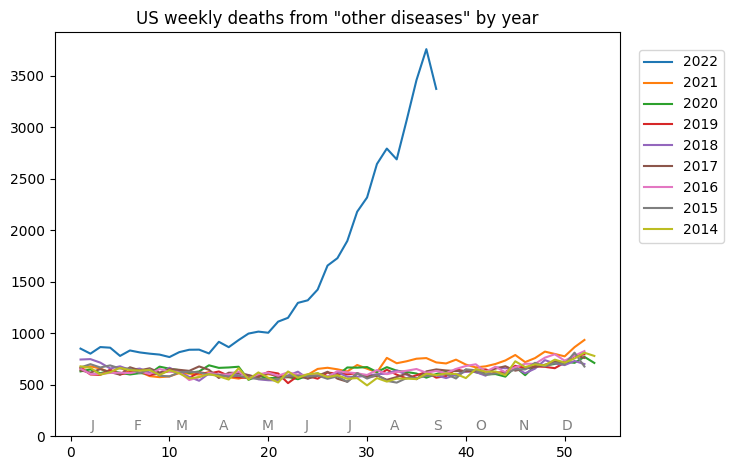

In [21]:
plot_cod_thru_yrs(['symptoms_signs_and_abnormal'], f'{loc_as_xx} weekly deaths from "other diseases" by year')

Deaths from 'other diseases' ("symptoms_signs_and_abnormal"--[icd10 page](https://icd-codes.com/icd10cm/R00-R99)) include yet-to-be-categorized deaths. CDC explained: the provisional flow contains records that are pending investigation and are initially coded to R95 when received in NCHS. These are slowly resolved by the states and eventually updated in NCHS (email from [NCHS](https://data.cdc.gov/browse?category=NCHS), 29jun2021).

In [22]:
# here are the raw data for 'other' deaths, including the weeks too recent to rely on, and thus excluded in the graphs.
other_cod_by_yr = select_col(loc_data_raw, 'symptoms_signs_and_abnormal')
#display(other_cod_by_yr)

# next steps

- add more precise dates to single-year plots.
- explore excess deaths by state/region.
- derive undercount_from_latest (a result used above), and maybe correct for it.
- want to help?  have a comment?  email me at john@saponara.us 
  or pursue any next step or code "todo" and please let me know.

# sources
- visit [here](https://github.com/jsaponara/pandemic_death_data/blob/main/deaths-us-natural_cause.ipynb) for complete details, including data sources and the code that generated these slides.